<a href="https://colab.research.google.com/github/phyuphyuthaw/portfolio-ML-AI/blob/main/TaxiTripDecisionTreeRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taxi Tip Prediction using Scikit-Learn and Snap ML**

Estimated time needed: **30** minutes

In this exercise session you will consolidate your machine learning (ML) modeling skills by using a popular regression model: Decision Tree. You will use a real dataset to train such a model. The dataset includes information about taxi tip and was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). You will use the trained model to predict the amount of tip paid.

In the current exercise session, you will practice not only the Scikit-Learn Python interface, but also the Python API offered by the Snap Machine Learning (Snap ML) library. Snap ML is a high-performance IBM library for ML modeling. It provides highly-efficient CPU/GPU implementations of linear models and tree-based models. Snap ML not only accelerates ML algorithms through system awareness, but it also offers novel ML algorithms with best-in-class accuracy. For more information, please visit https://www.zurich.ibm.com/snapml/.


In [ ]:
#link to google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [ ]:
#Import the dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/data/yellow_tripdata_2019-06.csv'

df = pd.read_csv(file_path)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [ ]:
print("There are " + str(len(df)) + " observations in the dataset.")
print("There are " + str(len(df.columns)) + " variables in the dataset.")

There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


<div id="dataset_analysis">
    <h2>Dataset Analysis</h2>
</div>


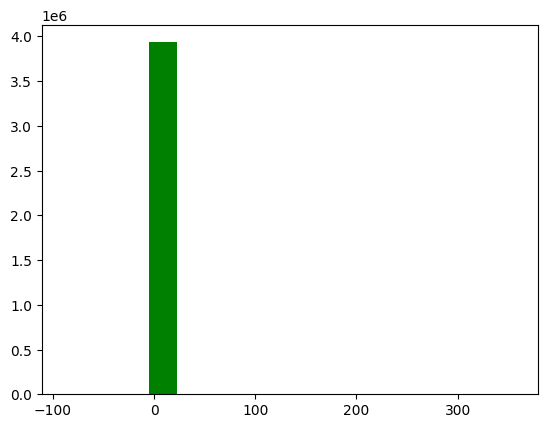

In [ ]:
plt.hist(df.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

In [ ]:
#data preprocessing
first_n_rows = 200000
df = df.head(first_n_rows)
# Convert 'tpep_dropoff_datetime' and 'tpep_pickup_datetime' columns to datetime objects
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Extract pickup and dropoff hour
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

# Extract pickup and dropoff day of the week (0 = Monday, 6 = Sunday)
df['pickup_day'] = df['tpep_pickup_datetime'].dt.weekday
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.weekday

# Calculate trip time in seconds
df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()

# drop the pickup and dropoff datetimes
df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(df, columns = get_dummy_col)

In [ ]:
del df
gc.collect()
# extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (200000, 572) y.shape= (200000, 1)


In [ ]:
#Creating training and testing dataset
#split the dataset into 70% train data and 30% test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
#Implement the model
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth = 8, random_state = 35)

# train a Decision Tree Regressor using scikit-learn
t0 = time.time()
model.fit(X_train, y_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  8.63583


<div id="dt_snapml">
    <h2>Build a Decision Tree Regressor model with Snap ML</h2>
</div>

In [ ]:
# Snap ML is available on PyPI. To install it simply run the pip command below.
!pip install snapml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 1.7 MB/s eta 0:00:00


In [ ]:
from snapml import DecisionTreeRegressor

# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, one needs to set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  4.75798


In [ ]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference using the sklearn model
sklearn_pred = model.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# run inference using the Snap ML model
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 1.82x 
[Scikit-Learn] MSE score : 1.693
[Snap ML] MSE score : 1.654


In [ ]:
new_snapml_dt = DecisionTreeRegressor(max_depth=12, random_state=45, n_jobs=4)

# train a Decision Tree Regressor model using Snap ML
t0 = time.time()
new_snapml_dt.fit(X_train, y_train)
new_snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(new_snapml_time))

[Snap ML] Training time (s):  6.21633


In [ ]:
#Predict new snapml_dt
y_pred = new_snapml_dt.predict(X_test)

new_snapml_mse = mean_squared_error(y_test, y_pred)
print('[New Snap ML] MSE score : {0:.3f}'.format(new_snapml_mse))

[New Snap ML] MSE score : 1.252
